In [1]:
import os
%pwd

'/workspaces/MLOps_data_science_pipeline/research'

In [2]:
os.chdir("../")
%pwd

'/workspaces/MLOps_data_science_pipeline'

In [3]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class DataTransformationConfig:
    root_dir: Path
    data_path: Path
    

In [4]:
from src.data_science.constants.constants import *
from src.data_science.utils.common import read_yaml, create_directories

In [5]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH,
        schema_filepath = SCHEMA_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)

        create_directories([self.config.artifacts_root])


    def get_data_transformation_config(self) -> DataTransformationConfig:
        config = self.config.data_transformation
        create_directories([config.root_dir])

        data_transformation_config = DataTransformationConfig(
            root_dir=config.root_dir,
            data_path= config.data_path,
        )

        return data_transformation_config

In [6]:
import os
from src.data_science.utils.logger import logger
from sklearn.model_selection import train_test_split
import pandas as pd

In [7]:
from typing import Optional, Dict, Any
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.backends.backend_pdf import PdfPages
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

In [16]:

class DataTransformation:
    def __init__(self, config:DataTransformationConfig):
        self.config = config
        os.makedirs(self.config.root_dir, exist_ok=True)

    def _save_figue(self, fig: plt.Figure, figure_name:str, save_png:bool=True, save_pdf:bool=False) -> tuple:
        """
        Helper function to save matplotlib figures as PNG and/or PDF files.
        Returns tuple of file paths where the figure is saved.
        """
        png_path = ""
        pdf_path = ""

        if save_png:
            png_path = os.path.join(self.config.root_dir, f"{figure_name}.png")
            fig.savefig(png_path, format="png", bbox_inches="tight", dpi=300)
            logger.info(f"Figure saved as PNG: {png_path}")

        if save_pdf:
            pdf_path = os.path.join(self.config.root_dir, f"{figure_name}.pdf")
            fig.savefig(pdf_path, format="pdf", bbox_inches="tight")
            logger.info(f"Figure saved as PDF: {pdf_path}")
        plt.close(fig)
        return png_path, pdf_path
        
    def train_test_splitting(self):
        data = pd.read_csv(self.config.data_path)
        train, test = train_test_split(data,test_size=0.2,random_state=42, shuffle=True)
        train.to_csv(os.path.join(self.config.root_dir, "train.csv"), index=False)
        test.to_csv(os.path.join(self.config.root_dir, "test.csv"), index=False)
        
        logger.info("Splited data into training and test sets")
        logger.info(train.shape)
        logger.info(test.shape)

        print(train.shape)
        print(test.shape)
        return train, test


    def basic_overview(self, df:Optional[pd.DataFrame] = None) -> Dict[str, Any]:
        if df is None:
            df = pd.read_csv(self.config.data_path)
        
        overview = {
            "shape": df.shape,
            "columns": df.columns.tolist(),
            "dtypes": df.dtypes.to_dict(),
            "missing_values": df.isnull().sum().to_dict(),
            "duplicate_rows": df.duplicated().sum(),
            "descriptive_stats": df.describe(include='all').to_dict()
        }

        missing_df = df.isnull().sum().reset_index()
        missing_df.columns = ['column', 'missing_count']
        missing_csv = os.path.join(self.config.root_dir, "missing_values.csv")
        missing_df.to_csv(missing_csv, index=False)
        logger.info(f"Missing values per column saved to {missing_csv}")

        dtypes_df = pd.DataFrame(df.dtypes.astype(str).reset_index())
        dtypes_df.columns = ['column', 'dtype']
        dtypes_csv = os.path.join(self.config.root_dir, "data_types.csv")
        dtypes_df.to_csv(dtypes_csv, index=False)
        logger.info(f"Data types per column saved to {dtypes_csv}")

        # Create a simple text figure summary and save as PDF as well

        fig, ax = plt.subplots(figsize=(8.27, 11.69))
        ax.axis('off')
        text = f"Shape: {overview['shape']}\n\nMissing Values:\n{missing_df.to_string(index=False)}\n\nData Types:\n{dtypes_df.to_string(index=False)}\n\nDescriptive Statistics:\n{pd.DataFrame(overview['descriptive_stats']).to_string()}"
        ax.text(0, 1, text, va='top', fontsize=10, family='monospace')
        self._save_figue(fig, "data_overview", save_png=False, save_pdf=True)

        logger.info(f"Basic data overview saved to {self.config.root_dir}")
        print("Shape:", df.shape)
        print("\nMissing values saved to:", missing_csv)
        print("Data types saved to:", dtypes_csv)

        return overview
    
    def encode_categoricals(self, df:Optional[pd.DataFrame] = None, target_col: Optional[str] = None) -> (pd.DataFrame, Dict[str, LabelEncoder]):
        if df is None:
            df = pd.read_csv(self.config.data_path)

        df_encoded = df.copy()
        label_encoders: Dict[str, LabelEncoder] = {}

        cat_cols = df_encoded.select_dtypes(include=['object', 'category']).columns.tolist()

        for col in cat_cols:
            if col == target_col:
                continue
            le = LabelEncoder()
            df_encoded[col] = df_encoded[col].fillna("__missing__").astype(str)
            df_encoded[col] = le.fit_transform(df_encoded[col])
            label_encoders[col] = le
            logger.info(f"Encoded column: {col}")

        logger.info("Categorical encoding completed")
        encoders_path = os.path.join(self.config.root_dir, "label_encoders.pkl")

        with open(encoders_path, 'wb') as f:
            import pickle
            pickle.dump(label_encoders, f)
        
        logger.info(f"Encoded {len(cat_cols)} categorical columns. Encoders saved to {encoders_path}")
        print(f"Encoded {len(cat_cols)} categorical columns. Encoders saved to {encoders_path}")

        return df_encoded, label_encoders
    
    def correlation_analysis(self, df:Optional[pd.DataFrame]= None, base_name:str = "correlation_heatmap"):
        if df is None:
            df = pd.read_csv(self.config.data_path)

        numeric_df = df.select_dtypes(include=[np.number])
        corr = numeric_df.corr()

        fig, ax = plt.subplots(figsize=(12, 10))
        cax = ax.matshow(corr, interpolation='nearest', cmap='coolwarm')
        fig.colorbar(cax)
        ax.set_xticks(range(len(corr.columns)))
        ax.set_xticklabels(corr.columns, rotation=90)
        ax.set_yticks(range(len(corr.columns)))
        ax.set_yticklabels(corr.columns)
        plt.title('Correlation Heatmap', pad=20)

        fig.tight_layout()
        png_path, pdf_path = self._save_figue(fig, base_name, save_png=True, save_pdf=True)

        corr_csv = os.path.join(self.config.root_dir, f"{base_name}.csv")
        corr.to_csv(corr_csv)
        logger.info(f"Correlation matrix saved to {corr_csv}")
        print(f"Correlation heatmap saved to: {png_path}, {pdf_path}")
        print(f"Correlation matrix saved to: {corr_csv}")

        logger.info("Correlation analysis completed")
        return corr
    
    def feature_importance(self, df:Optional[pd.DataFrame] = None, target_col: str = "target", base_name: str = "mutual_info"):
        if df is None:
            df = pd.read_csv(self.config.data_path)

        if target_col not in df.columns:
            raise ValueError(f"Target column '{target_col}' not found in DataFrame")

        X = df.drop(columns=[target_col])
        y = df[target_col]

        X_proc = X.copy()
        for col in X_proc.select_dtypes(include=['object', 'category']).columns:
            X_proc[col] = X_proc[col].fillna("__missing__").astype(str)
            le = LabelEncoder()
            X_proc[col] = le.fit_transform(X_proc[col])
        
        X_proc = X_proc.fillna(X_proc.median())

        mi = mutual_info_classif(X_proc, y, discrete_features='auto', random_state=42)
        mi_series = pd.Series(mi, index=X_proc.columns).sort_values(ascending=False)

        mi_csv = os.path.join(self.config.root_dir, f"{base_name}_feature_importance.csv")
        mi_series.to_csv(mi_csv, header=["mutual_info"])
        logger.info(f"Feature importance saved to {mi_csv}")
        print(f"Feature importance saved to: {mi_csv}")

        fig, ax = plt.subplots(figsize=(10, 6))
        mi_series.plot.bar(ax=ax)
        ax.set_title('Feature Importance (Mutual Information)')
        ax.set_ylabel('Mutual Information Score')
        fig.tight_layout()
        png_path, pdf_path = self._save_figue(fig, base_name, save_png=True, save_pdf=True)
        print(f"Feature importance plot saved to: {png_path}, {pdf_path}")
        logger.info("Feature importance analysis completed")
        return mi_series
    
    def pca_analysis(self, df:Optional[pd.DataFrame] = None, target_col: Optional[str] = None, base_name: str = "pca_analysis", n_components: int = 2):
        if df is None:
            df = pd.read_csv(self.config.data_path)

        if target_col and target_col not in df.columns:
            raise ValueError(f"Target column '{target_col}' not found in DataFrame")
        
        X = df.drop(columns=[target_col]) if target_col else df.copy()
        X = X.select_dtypes(include=[np.number]).fillna(X.median())

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        pca = PCA(n_components=n_components, random_state=42)
        X_pca = pca.fit_transform(X_scaled)

        explained_variance = pca.explained_variance_ratio_
        logger.info(f"PCA explained variance ratios: {explained_variance}")
        print(f"PCA explained variance ratios: {explained_variance}")

        pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components)])

        fig, ax = plt.subplots(figsize=(8, 6))
        if target_col:
            y = df[target_col]
            if y.dtype == 'object' or y.dtype.name == 'category':
                le = LabelEncoder()
                y = le.fit_transform(y.fillna("__missing__").astype(str))
            sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
            fig.colorbar(sc, ax=ax, label=target_col)
        else:
            ax.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7)
        ax.set_xlabel('Principal Component 1')
        ax.set_ylabel('Principal Component 2')
        ax.set_title('PCA Analysis')
        fig.tight_layout()
        png_path, pdf_path = self._save_figue(fig, base_name, save_png=True, save_pdf=True)
        print(f"PCA plot saved to: {png_path}, {pdf_path}")
        logger.info("PCA analysis completed")

        explained = pd.Series(explained_variance, index=[f'PC{i+1}' for i in range(n_components)])  
        explained_csv = os.path.join(self.config.root_dir, f"{base_name}_explained_variance.csv")
        explained.to_csv(explained_csv, header=["explained_variance"])
        logger.info(f"PCA explained variance saved to {explained_csv}")
        print(f"PCA explained variance saved to: {explained_csv}")

        return X_pca, explained
    
    def chi_square_test(self, df:Optional[pd.DataFrame] = None, target_col: str = "target", base_name: str = "chi_square"):
        from scipy.stats import chi2_contingency


        df = pd.read_csv(self.config.data_path)
        target_col = target_col or self.config.target_col

        if target_col not in df.columns:
            raise ValueError(f"Target column '{target_col}' not found in DataFrame")

        cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
        if target_col in cat_cols:
            cat_cols.remove(target_col)

        if not cat_cols:
            print("⚠️ No categorical columns found for chi-square test. Skipping...")
            return None

        results = {}
        for col in cat_cols:
            contingency_table = pd.crosstab(df[col], df[target_col])
            chi2, p, dof, _ = chi2_contingency(contingency_table)
            results[col] = {"feature": col, "chi2_statistic": chi2, "p_value": p}

        chi2_df = pd.DataFrame(results).T.reset_index(drop=True)

        # Only plot if we got results
        if not chi2_df.empty:
            fig, ax = plt.subplots(figsize=(10, 6))
            chi2_df.set_index('feature')['chi2_statistic'].sort_values(ascending=False).plot.bar(ax=ax)
            ax.set_title('Chi-Square Statistics for Categorical Features')
            ax.set_ylabel('Chi-Square Statistic')
            plt.tight_layout()

        return chi2_df

    
    def tsne_analysis(self, df:Optional[pd.DataFrame] = None, target_col: Optional[str] = None, base_name: str = "tsne_analysis", n_components: int = 2, perplexity: int = 30):
        if df is None:
            df = pd.read_csv(self.config.data_path)

        if target_col and target_col not in df.columns:
            raise ValueError(f"Target column '{target_col}' not found in DataFrame")
        
        X = df.drop(columns=[target_col]) if target_col else df.copy()
        X_proc = X.copy()
        for col in X_proc.select_dtypes(include=['object', 'category']).columns:
            X_proc[col] = X_proc[col].fillna("__missing__").astype(str)
            le = LabelEncoder()
            X_proc[col] = le.fit_transform(X_proc[col])
        
        X_proc = X_proc.select_dtypes(include=[np.number]).fillna(X_proc.median())

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_proc)

        tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=42)
        X_tsne = tsne.fit_transform(X_scaled)

        tsne_df = pd.DataFrame(X_tsne, columns=[f'tSNE{i+1}' for i in range(n_components)])

        fig, ax = plt.subplots(figsize=(8, 6))
        if target_col:
            y = df[target_col]
            if y.dtype == 'object' or y.dtype.name == 'category':
                le = LabelEncoder()
                y = le.fit_transform(y.fillna("__missing__").astype(str))
            sc = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', alpha=0.7)
            fig.colorbar(sc, ax=ax, label=target_col)
        else:
            ax.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7)
        ax.set_xlabel('t-SNE Component 1')
        ax.set_ylabel('t-SNE Component 2')
        ax.set_title('t-SNE Analysis')
        fig.tight_layout()
        png_path, pdf_path = self._save_figue(fig, base_name, save_png=True, save_pdf=True)
        print(f"t-SNE plot saved to: {png_path}, {pdf_path}")
        logger.info("t-SNE analysis completed")

        return X_tsne

    def detect_outliers_isolation_forest(self, df: Optional[pd.DataFrame] = None, contamination: float = 0.01,
                                         return_scores: bool = False, save_name: str = "outliers.csv"):
        if df is None:
            df = pd.read_csv(self.config.data_path)

        X = df.select_dtypes(include=[np.number]).fillna(0)
        iso = IsolationForest(contamination=contamination, random_state=42)
        preds = iso.fit_predict(X)  # -1 for outliers, 1 for inliers
        scores = iso.decision_function(X)

        outliers_df = df.copy()
        outliers_df["_is_outlier"] = (preds == -1).astype(int)
        if return_scores:
            outliers_df["_outlier_score"] = scores

        save_path = os.path.join(self.config.root_dir, save_name)
        outliers_df.to_csv(save_path, index=False)

        # also save a small histogram of outlier scores as PDF
        try:
            fig, ax = plt.subplots(figsize=(8, 4))
            ax.hist(scores, bins=50)
            ax.set_title("IsolationForest outlier scores")
            ax.set_xlabel("score")
            ax.set_ylabel("count")
            fig.tight_layout()
            self._save_figure(fig, "outlier_scores_hist", save_png=True, save_pdf=True)
        except Exception as e:
            logger.warning(f"Failed to save outlier scores plot: {e}")

        logger.info(f"Outlier flags saved to {save_path}")
        return outliers_df


[2025-09-24 06:26:30,163 - INFO - common - yaml file: config/config.yaml loaded successfully!]
[2025-09-24 06:26:30,165 - INFO - common - yaml file: params.yaml loaded successfully!]
[2025-09-24 06:26:30,168 - INFO - common - yaml file: schema.yaml loaded successfully!]
[2025-09-24 06:26:30,169 - INFO - common - created directory at: artifacts]
[2025-09-24 06:26:30,171 - INFO - common - created directory at: artifacts/data_transformation]
[2025-09-24 06:26:30,197 - INFO - 3755210814 - Splited data into training and test sets]
[2025-09-24 06:26:30,197 - INFO - 3755210814 - (1279, 12)]
[2025-09-24 06:26:30,201 - INFO - 3755210814 - (320, 12)]
(1279, 12)
(320, 12)
[2025-09-24 06:26:30,230 - INFO - 3755210814 - Missing values per column saved to artifacts/data_transformation/missing_values.csv]
[2025-09-24 06:26:30,233 - INFO - 3755210814 - Data types per column saved to artifacts/data_transformation/data_types.csv]
[2025-09-24 06:26:30,422 - INFO - 3755210814 - Figure saved as PDF: artifa

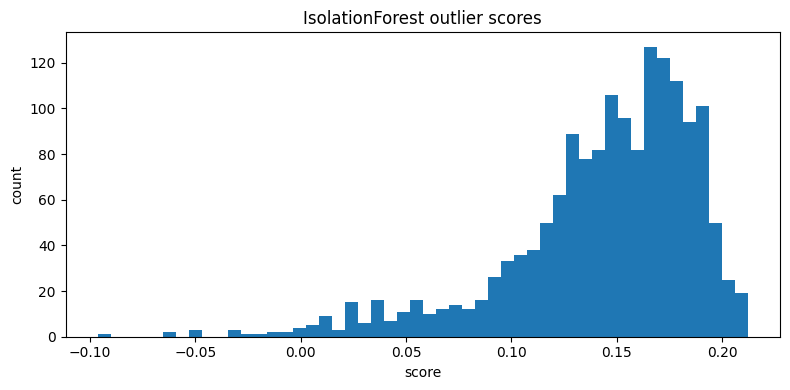

In [17]:
try:
    config = ConfigurationManager()
    data_transformation_config = config.get_data_transformation_config()
    data_transformation = DataTransformation(config=data_transformation_config)
    data_transformation.train_test_splitting()
    data_transformation.basic_overview()
    data_transformation.chi_square_test(target_col="quality")
    data_transformation.correlation_analysis()
    data_transformation.feature_importance(target_col="quality")
    data_transformation.pca_analysis(target_col="quality")
    data_transformation.tsne_analysis(target_col="quality")
    data_transformation.detect_outliers_isolation_forest(contamination=0.01, return_scores=True)
except Exception as e:
    raise e